# 3 Coloring Zero Knowledge Proof
The following shows an interactive proof for Graph 3 Coloring. Recall that a $k$-col for a graph $G = (V, E)$ is a function $\pi: V \to \mathbb{N}_k$ such that $(u, v) \in E \implies \phi(u) \neq \phi(v)$. So a mapping to the set $\{1, \dots, k \}$ such that neighbouring vertexes are mapped to different classes.  
We make use of commitments, which are a way to ensure that the prover chooses some values that it cannot then arbitrarly change without the verifier knowing. In particular, we use Python's pseudorandom generator for this aim (Note that this is not a particolarly strong commitment scheme, but for illustration purposes it should be fine).
The protocol works as following:
1. The prover selects a random permutation $\sigma$ and sets $\phi \equiv \sigma \circ \pi$
2. It then select random strings $r_i$ and computes the commitments $c_i \equiv C_{r_i}(\phi(i))$. The provers sends $c_1, \dots\, c_n$ to the verifier
3. The verifier selects at random an edge $(u, v)$
4. The prover sends the reveal of the commitments of $c_u, c_v$, namely $(r_u, \phi(u)), (r_v, \phi(v))$, to the verifier
5. Finally, the verifier checks that $\phi(u) \neq \phi(v)$ and that $C_{r_u}(\phi(u)) = c_u$ and $C_{r_v}(\phi(v))$. If it holds then it accepts

Let us start showing the protocol. In particular, first we define the parameters and the routines that we will be using. We will generate some random tripartite graphs, which almost by definition are 3 colorable. 

In [153]:
V = 12
E = 40

def generate_with_three_col(V, E):
    # We generate a random three partite
    if V % 3 != 0:
        return
    vertexes = list(range(1, V + 1))
    chunk_size = V // 3
    # First divide in three sets
    partitions = [vertexes[:chunk_size],vertexes[chunk_size:2*chunk_size],vertexes[2*chunk_size:]]
    edges = set()
    while E > 0:
        # Chose two distinct classes
        first_class = randrange(0, 3)
        second_class = choice(list(set([0, 1, 2]).difference([first_class])))
        # Chose two distinct nodes and make an edge
        first_node, second_node = randrange(0, chunk_size), randrange(0, chunk_size)
        edge = (partitions[first_class][first_node], partitions[second_class][second_node])
        if edge in edges:
            continue
        edges.add(edge)
        E = E - 1
    
    col = lambda x: 1 if x in partitions[0] else 2 if x in partitions[1] else 3
    return Graph(list(edges)), col

def commit(color, random, N):
    # We use a fixed seed to reproduce
    set_random_seed(random)
    r = current_randstate().python_random(seed=random)
    return (r.getrandbits(3 * N), ((random ^ random) % 2) ^ color)
    
def compose(function, perm):
    return lambda i: perm(function(i))

We generate the graph, and find the coloring that is taken as private to the prover. Then we select a random $\sigma$ and permute the coloring $\pi$ with it

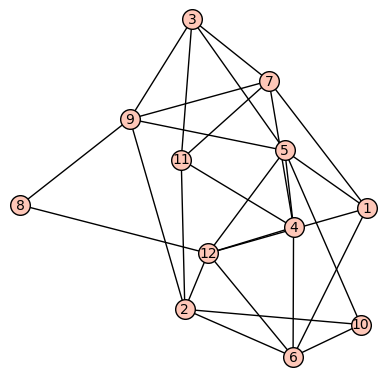

In [154]:
G, pi = generate_with_three_col(V, E)
sigma = Permutation(Permutations(3).random_element())
phi = compose(pi, sigma)

random_strings = [getrandbits(V) for _ in G.vertices()]
commitments = map(lambda (a, b): commit(a, b, V), zip([phi(i) for i in G.vertices()], random_strings))

G.show()

Now the verifier selects a random edge as a challenge

In [155]:
u, v = G.random_edge(labels = False)
(u, v)

(4, 7)

The prover sends to the verifier the values that it used to commit the selected edges. (The factor of -1 is due to the fact that arrays in python are 0 indexed)

In [156]:
r_u = random_strings[u - 1]
color_u = phi(u)
r_v = random_strings[v - 1]
color_v = phi(v)

(r_u, color_u), (r_v, color_v)

((3995L, 1), (2642L, 2))

Finally, the verifier checks that the values are consistent for 3 coloring, and that the commitments are valid. If so it accepts

In [157]:
coloring_valid = color_u != color_v
valid_start_commitment = commitments[u - 1] == commit(color_u, r_u, V)
valid_end_commitment = commitments[v - 1] == commit(color_v, r_v, V)
coloring_valid and valid_start_commitment and valid_end_commitment

True

# Experiment



In [159]:
class HonestVerifier:
    def __init__(self, G):
        self.G = G
        
    def challenge(self, commitments):
        self.commitments = commitments
        self.u, self.v = self.G.random_edge(labels = False)
        return (self.u, self.v)
    
    def verify(self, r_u, color_u, r_v, color_v):
        coloring_valid = color_u != color_v
        valid_start_commitment = self.commitments[self.u - 1] == commit(color_u, r_u, V)
        valid_end_commitment = self.commitments[self.v - 1] == commit(color_v, r_v, V)
        return coloring_valid and valid_start_commitment and valid_end_commitment
        
    
def procedure_honest_prover(G, pi, ver):
    # First we permute the original coloring
    sigma = Permutation(Permutations(3).random_element())
    phi = compose(pi, sigma)

    # Compute the commitments
    random_strings = [getrandbits(V) for _ in G.vertices()]
    commitments = map(lambda (a, b): commit(a, b, V), zip([phi(i) for i in G.vertices()], random_strings))
    
    # Verifier init and challenge
    ver = ver(G)
    u, v = ver.challenge(commitments)
    
    # Get the values used for committing the values
    r_u = random_strings[u - 1]
    color_u = phi(u)
    r_v = random_strings[v - 1]
    color_v = phi(v)
    
    # Check if the verifier accepts
    return verifier.verify(r_u, color_u, r_v, color_v)